In [1]:
import numpy as np
from DefineBoundaryFittedGeometries import define_geometry
from ShowMeshesForBoundaryFittedGeometries import show_mesh_for_boundary_fitted_geometries
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Geometry

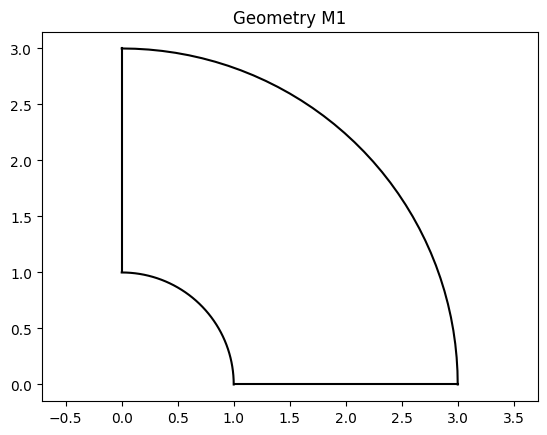

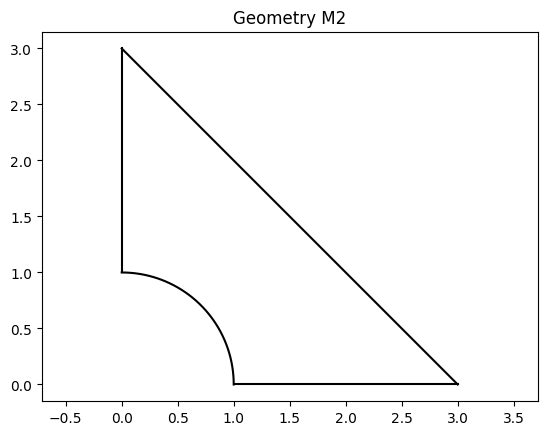

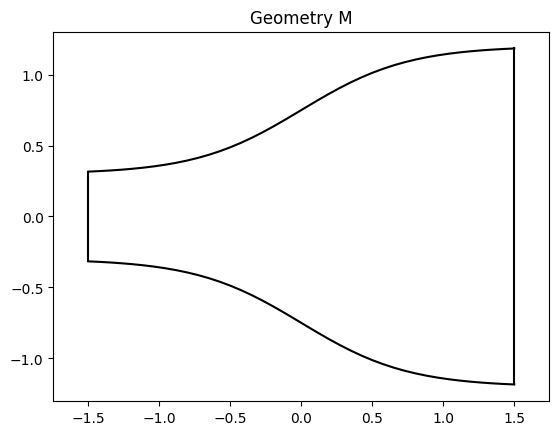

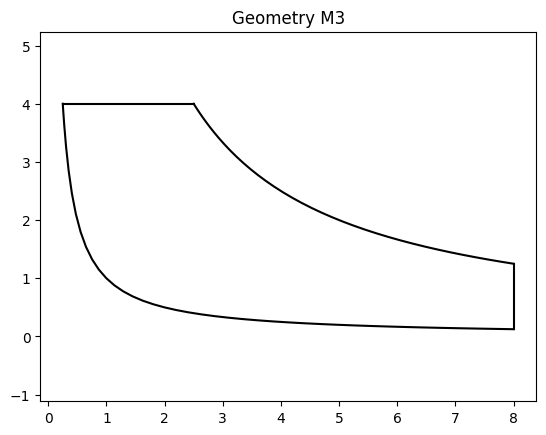

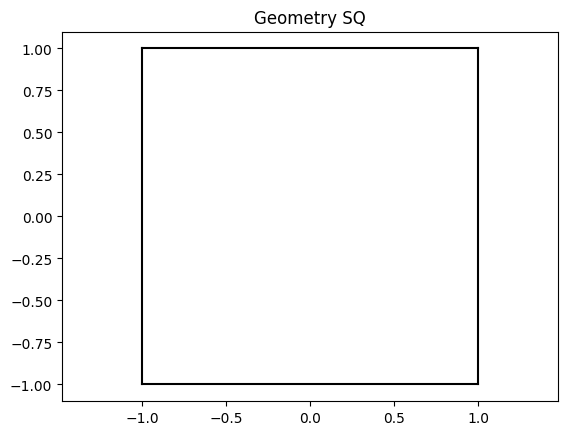

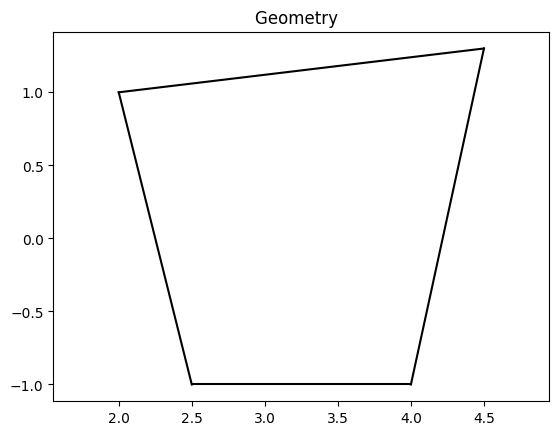

In [3]:
# Show available geometry shapes. 

for G in ['M1', 'M2', 'M', 'M3', 'SQ', ' ']:
    define_geometry(G, show_geometry=True)

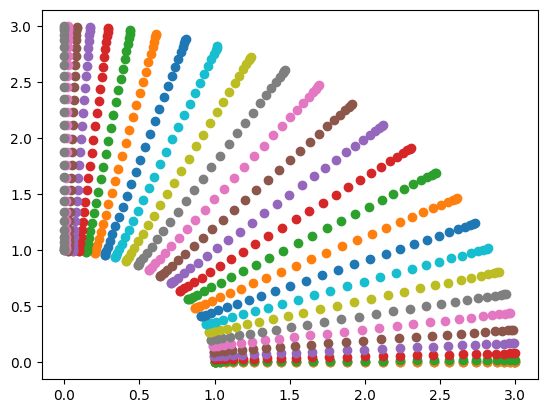

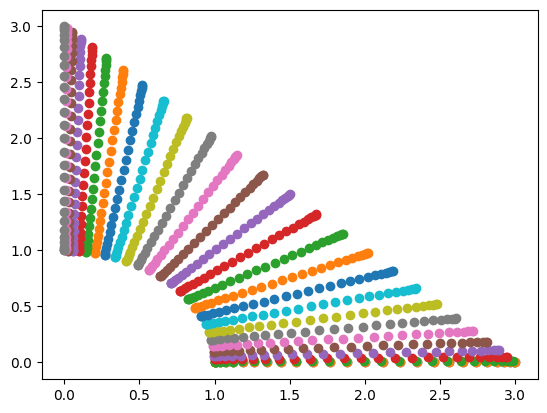

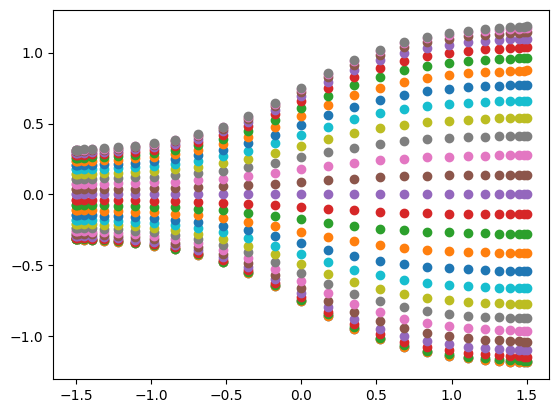

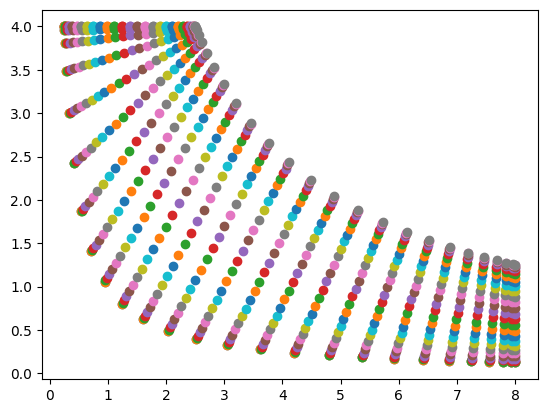

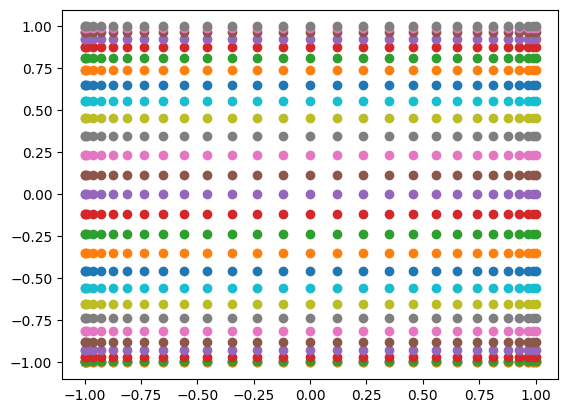

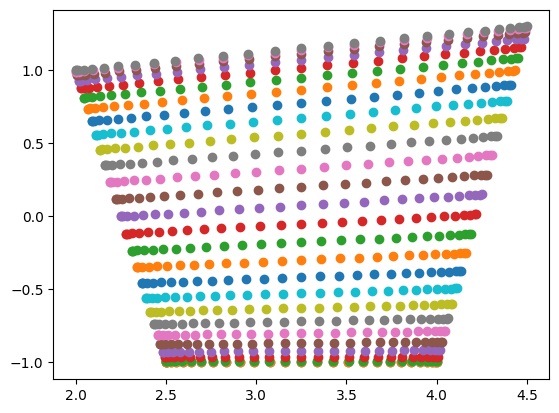

In [ ]:
# Show the meshes/points for each geometry. 

for G in ['M1', 'M2', 'M', 'M3', 'SQ', ' ']:
    X, Y = show_mesh_for_boundary_fitted_geometries(G, print_on_off=False, plot=False)
    plt.figure()
    for i in range(X.shape[0]):
        plt.scatter(X[i], Y[i])
    plt.show()

In [7]:
# Define and sample geometry for physics loss. 
# NB: Code only tested for 'M1' geometry. 

geometry = 'M1' 

physics_xs, physics_ys = show_mesh_for_boundary_fitted_geometries(geometry)

In [53]:
# Create array of all coordinates. 

physics_xys = np.zeros((physics_xs.shape[0], physics_xs.shape[1], 2))
for i in range(physics_xs.shape[0]):
    physics_xys[i] = np.column_stack((physics_xs[i], physics_ys[i]))

physics_xys = np.reshape(physics_xys, (physics_xs.shape[0]*physics_xs.shape[1], 2))

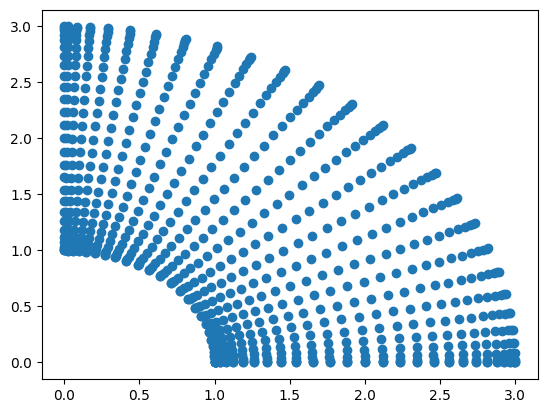

In [54]:
plt.scatter(physics_xys[:, 0], physics_xys[:, 1])
plt.show()

In [55]:
# Create interior array.

interior_xys = np.zeros((physics_xs.shape[0] - 2, physics_xs.shape[1] - 2, 2))
for i in range(physics_xs.shape[0]-2):
    interior_xys[i] = np.column_stack((physics_xs[i, 1:-1], physics_ys[i, 1:-1]))

interior_xys = np.reshape(interior_xys, ((physics_xs.shape[0] - 2) * (physics_xs.shape[1] - 2), 2))

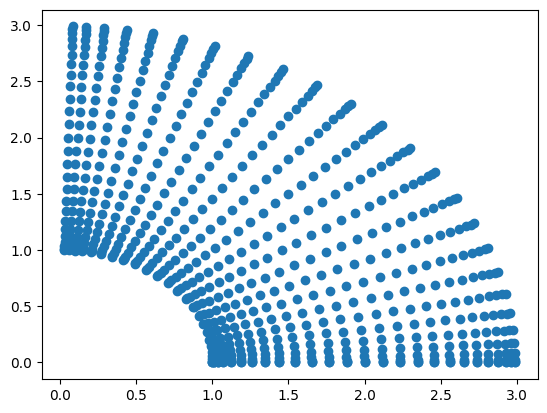

In [56]:
plt.scatter(interior_xys[:, 0], interior_xys[:, 1])
plt.show()

In [36]:
# Create inlet, outlet and walls arrays. 

inlet_xys = np.stack((physics_xs[-1], physics_ys[-1]))
outlet_xys = np.stack((physics_xs[0], physics_ys[0]))

right_wall_xs = physics_xs[:, 0]
right_wall_ys = physics_ys[:, 0]

left_wall_xs = physics_xs[:, -1]
left_wall_ys = physics_ys[:, -1]

left_wall_xys = np.stack((left_wall_xs, left_wall_ys))
right_wall_xys = np.stack((right_wall_xs, right_wall_ys))

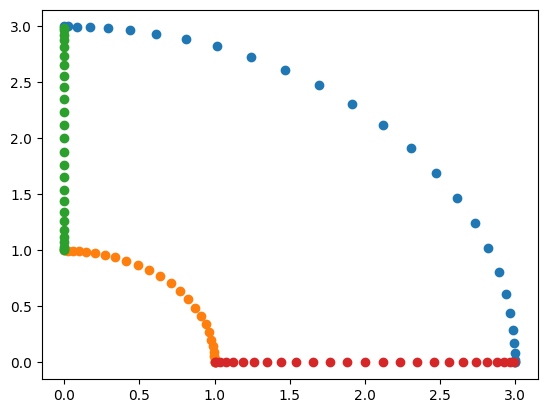

In [46]:
plt.scatter(left_wall_xys[0, :], left_wall_xys[1, :])
plt.scatter(right_wall_xys[0, :], right_wall_xys[1, :])
plt.scatter(inlet_xys[0, 1:-1], inlet_xys[1, 1:-1])
plt.scatter(outlet_xys[0, 1:-1], outlet_xys[1, 1:-1])
plt.show()

In [ ]:
# Define network architecture.

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


In [ ]:
# Create the training loop. 
# Include training data when available or just use physics loss. 

# data_x = xs_training
# data_y = ys_training

# torch.manual_seed(123)
model = FullyConnected(2, 64, 1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
scheduler = StepLR(optimizer2, step_size=10000, gamma=0.9)

for i in range(200000):
  optimizer2.zero_grad()

  # data loss
  # pred_y = model(data_x)
  # data_loss = torch.mean((pred_y - data_y) ** 2) # Mean squared error

  # physics loss
  physics_pred = model(physics_xys)
  dx = torch.autograd.grad(physics_pred, physics_xs, torch.ones_like(physics_pred_y), create_graph=True)[0]
  dx2 = torch.autograd.grad(dx, physics_xs, torch.ones_like(dx), create_graph=True)[0]
  residual = dx2 + mu * dx + k * physics_pred_y

  physics_loss = torch.mean(residual**2)

  # boundary conditions loss
  t_boundary = torch.zeros(1, requires_grad=True) # torch.tensor([0])
  x_boundary = torch.ones(1, requires_grad=True) #torch.tensor([1])
  # dx_boundary = torch.zeros(1, requires_grad=True) #torch.tensor([0])
  x0_predicted = model(t_boundary)
  dx_predicted = torch.autograd.grad(x0_predicted, t_boundary, torch.ones_like(t_boundary), create_graph=True)[0]
  residual_x0 = x0_predicted - x_boundary
  # residual_dx = dx_predicted
  boundary_loss = torch.mean(residual_x0 ** 2) #+ torch.mean(residual_dx ** 2)

  # boundary_conditions_loss =

  loss = boundary_loss + (1e-4) * physics_loss + data_loss #data_loss + (1e-6)*physics_loss
  loss.backward()
  optimizer2.step()
  scheduler.step()

  if (i+1) % 2000 == 0:
    detached_t = physics_xs.detach()
    print(boundary_loss, physics_loss, data_loss)
    pred_ys = model(x).detach()
    plt.plot(x, pred_ys)
    plt.plot(x, y)
    # plt.scatter(detached_t, torch.zeros_like(detached_t))
    #plt.scatter(short_input_time, short_output_displacement)
    plt.title('Predictions after step '+str(i))
    plt.show()
